In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions, plot_xgb_feature_importance


In [3]:
sheet = pd.read_excel('data_input_auto/煤油裂解价差拟合残差_布伦特迪拜.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['新加坡航空煤油裂解价差拟合残差/布伦特迪拜掉期 EFS（路透）'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=21, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

,新加坡航空煤油裂解价差拟合残差/布伦特迪拜掉期 EFS（路透）,美国经济惊喜指数超季节性/3年,中美经济预期差指数,石脑油-布油价差,南华工业品指数超季节性/3年,煤油：产量：中国（周）同差,新加坡10ppm柴油裂解
2025-11-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-11-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
sheet3 = pd.ExcelFile('eta/新加坡10ppm柴油裂解_合并数据.xlsx').parse('Sheet1')
sheet3['Date'] = pd.to_datetime(sheet3['Date'], errors='coerce')
sheet3 = sheet3.sort_values('Date', ascending=True)
sheet3 = sheet3.drop(columns=['真实值'])
sheet3 = sheet3.dropna()
sheet3.head()

,Date,预测值
29,2025-10-20,20.0
28,2025-10-21,20.0
27,2025-10-22,20.4
26,2025-10-23,20.1
25,2025-10-24,20.0


In [5]:
# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

sheet_daily = pd.merge(
    sheet_daily,
    sheet3[['Date', '预测值']],
    on='Date',
    how='left'
)
sheet_daily['新加坡10ppm柴油裂解'] = sheet_daily['新加坡10ppm柴油裂解'].fillna(sheet_daily['预测值'])
sheet_daily = sheet_daily.drop(columns=['预测值'])

# 将 sheet_daily 重新赋值给 sheet
sheet = sheet_daily.copy()
sheet = sheet.set_index('Date')
sheet.tail(2)

,新加坡航空煤油裂解价差拟合残差/布伦特迪拜掉期 EFS（路透）,美国经济惊喜指数超季节性/3年,中美经济预期差指数,石脑油-布油价差,南华工业品指数超季节性/3年,煤油：产量：中国（周）同差,新加坡10ppm柴油裂解
Date,,,,,,,
2025-11-20,NaN,NaN,NaN,NaN,NaN,NaN,19.1
2025-11-21,NaN,NaN,NaN,NaN,NaN,NaN,19.1


In [6]:
################################# 处理缺失值 #################################
fill_methods = {
'美国经济惊喜指数超季节性/3年': 'interpolate', 
'中美经济预期差指数': 'interpolate', 
'石脑油-布油价差' : 'interpolate' ,
'煤油：产量：中国（周）同差': 'interpolate', 
'新加坡10ppm柴油裂解': 'interpolate'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)

#################################  因子处理  #################################

sheet['美国经济惊喜指数超季节性/3年_提前30天'] = sheet['美国经济惊喜指数超季节性/3年'].shift(35)
sheet['中美经济预期差指数_提前20天'] = sheet['中美经济预期差指数'].shift(20)
sheet['石脑油-布油价差_提前60天'] = sheet['石脑油-布油价差'].shift(60)
sheet['煤油：产量：中国（周）同差_提前30天'] = sheet['煤油：产量：中国（周）同差'].shift(30)

sheet['石脑油-布油价差_提前60天_逆序'] = reverse_column(sheet, '石脑油-布油价差_提前60天')
sheet['中美经济预期差指数_提前20天_逆序'] = reverse_column(sheet, '中美经济预期差指数_提前20天')
################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-01-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['新加坡航空煤油裂解价差拟合残差/布伦特迪拜掉期 EFS（路透）'].notna())
]

################################# 数据 读取-处理 结束 #################################

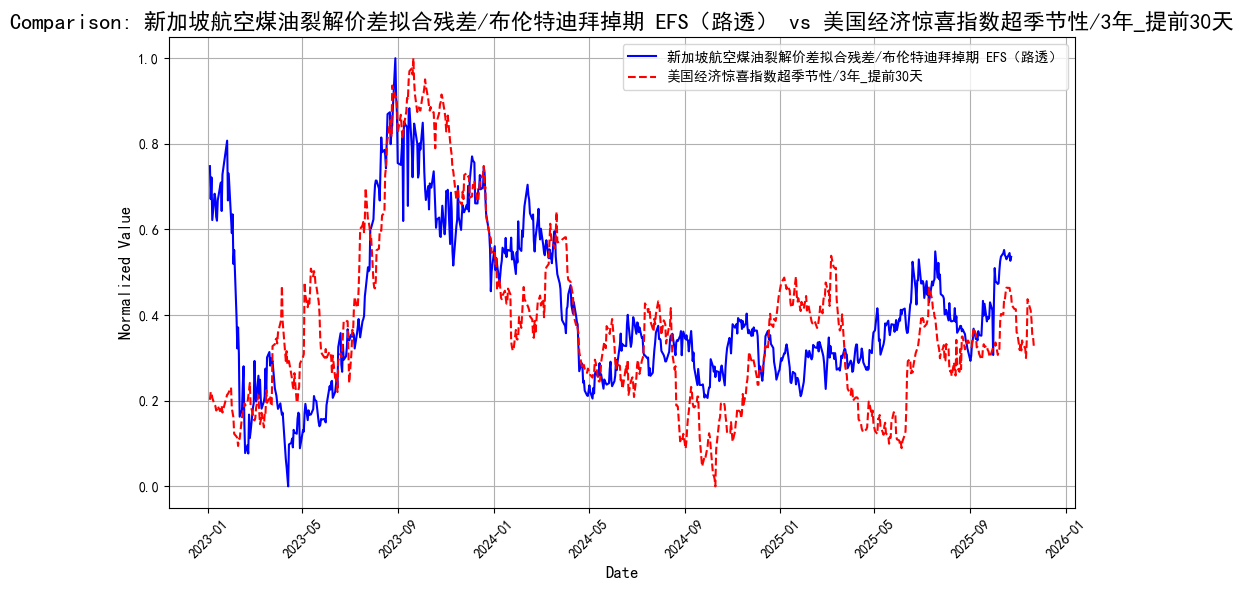

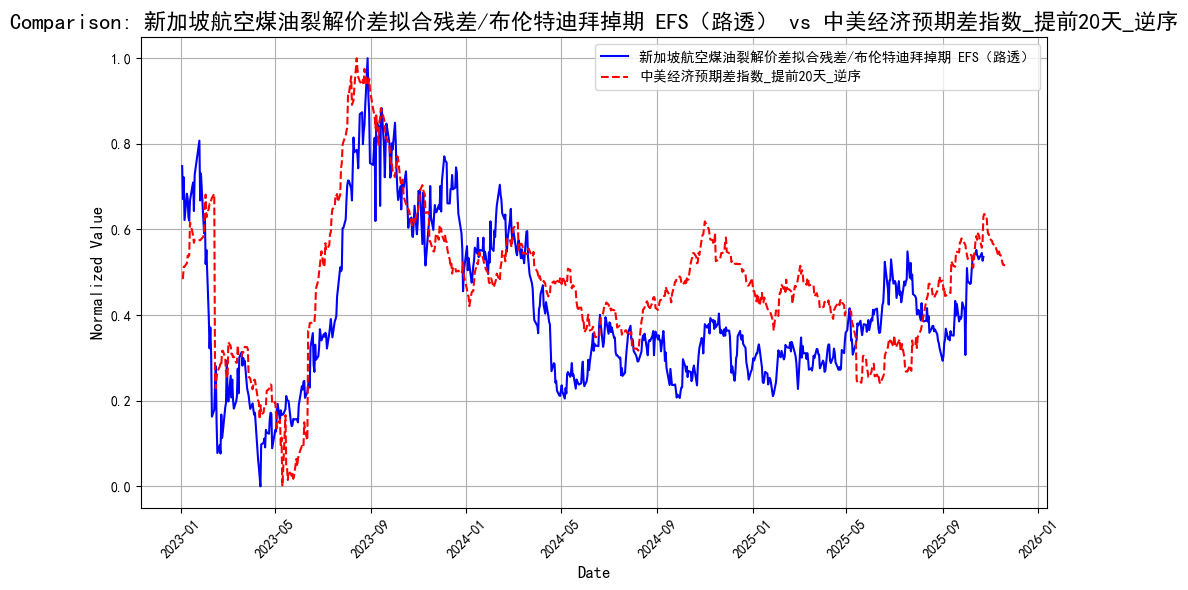

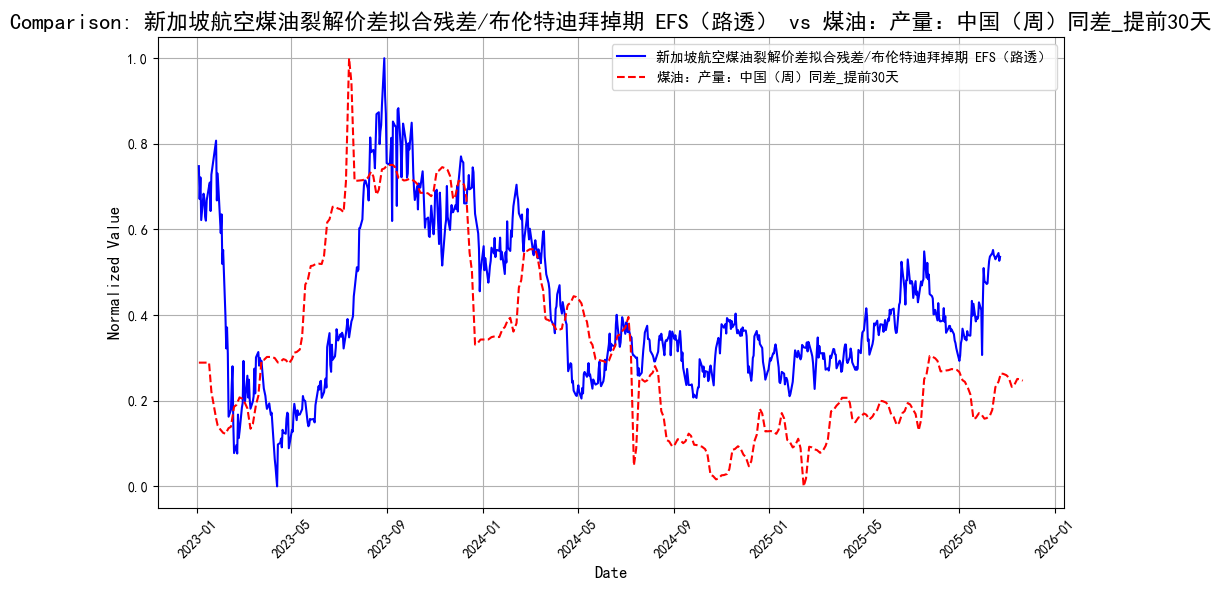

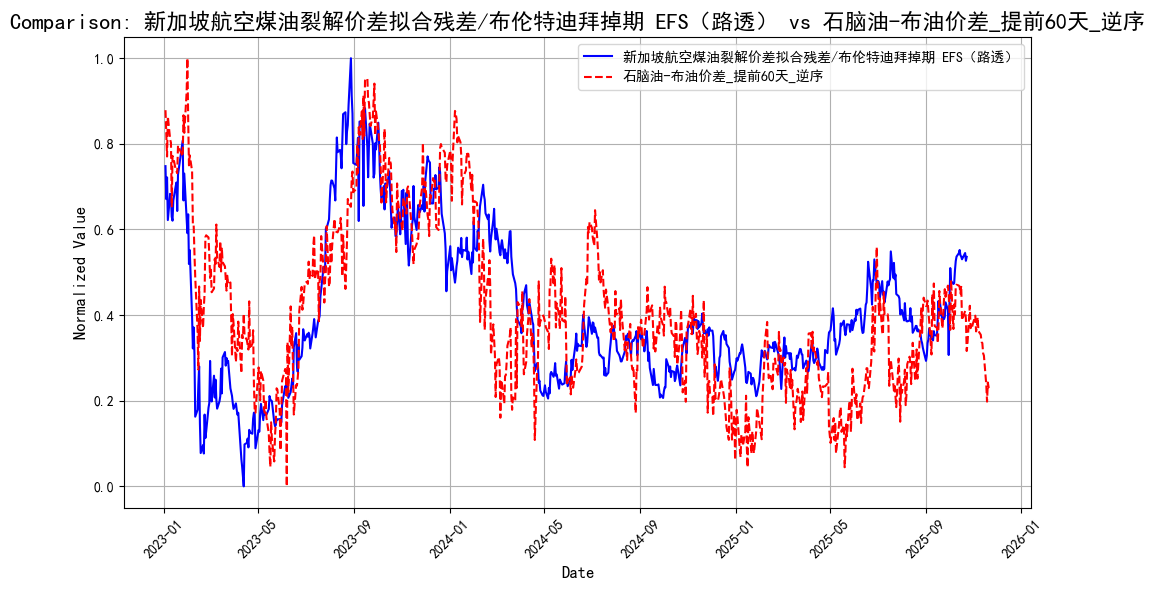

In [7]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='新加坡航空煤油裂解价差拟合残差/布伦特迪拜掉期 EFS（路透）', 
    compare_cols=[
        '美国经济惊喜指数超季节性/3年_提前30天',
        '中美经济预期差指数_提前20天_逆序',
        '煤油：产量：中国（周）同差_提前30天',
        '石脑油-布油价差_提前60天_逆序'
        ]
)

In [8]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 60
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        '美国经济惊喜指数超季节性/3年_提前30天',
        '中美经济预期差指数_提前20天_逆序',
        '煤油：产量：中国（周）同差_提前30天',
        '石脑油-布油价差_提前60天_逆序',
        '新加坡10ppm柴油裂解'
]

predict_column = '新加坡航空煤油裂解价差拟合残差/布伦特迪拜掉期 EFS（路透）'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 85)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.05,  # 较小的学习率
    'max_depth': 4,  # 控制树的深度防止过拟合
    'min_child_weight': 5,  # 控制过拟合
    'subsample': 0.7,  # 随机采样防止过拟合
    'colsample_bytree': 0.7,  # 特征随机采样
    'gamma': 0.5,  # 控制分裂
    'reg_alpha': 1,  # L1正则化
    'reg_lambda': 1.4775,  # L2正则化
    'eval_metric': 'rmse', # 评估指标：选择“rmse”
    'seed': 42, # 随机种子
    'max_delta_step': 15,
#    'tree_method': 'auto'
}

num_boost_round = 3000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=500 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:2.40073	train-rmse:5.58018


[500]	eval-rmse:2.09810	train-rmse:0.61029


[1000]	eval-rmse:2.07775	train-rmse:0.50049


[1500]	eval-rmse:2.07177	train-rmse:0.46823


[2000]	eval-rmse:2.07538	train-rmse:0.45107


[2500]	eval-rmse:2.07130	train-rmse:0.44213

[2999]	eval-rmse:2.07191	train-rmse:0.43657

训练集 MSE (DMatrix): 0.1997, 训练集 R² (DMatrix): 0.9947
测试集 MSE (DMatrix): 4.2928, 测试集 R² (DMatrix): 0.2305


In [9]:
'''
# 导入random模块
import random

# 定义参数搜索空间
param_space = {
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [2, 3, 4, 5],
    'subsample': [0.5, 0.6, 0.7, 0.8],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'gamma': [0.5, 1, 1.5, 2],
    'reg_alpha': [0.1, 0.3738, 0.5, 1],
    'reg_lambda': [0.5, 1, 1.4775, 2],
    'max_delta_step': [5, 10, 15, 20]
}

# 随机搜索次数
n_iter = 100

best_rmse = float('inf')
best_params = {}

for i in range(n_iter):
    # 随机选择参数
    current_params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'seed': 42,
        'learning_rate': random.choice(param_space['learning_rate']),
        'max_depth': random.choice(param_space['max_depth']), 
        'min_child_weight': random.choice(param_space['min_child_weight']),
        'subsample': random.choice(param_space['subsample']),
        'colsample_bytree': random.choice(param_space['colsample_bytree']),
        'gamma': random.choice(param_space['gamma']),
        'reg_alpha': random.choice(param_space['reg_alpha']),
        'reg_lambda': random.choice(param_space['reg_lambda']),
        'max_delta_step': random.choice(param_space['max_delta_step'])
    }
    
    # 训练模型
    evals_result = {}
    model = xgb.train(
        current_params,
        train_dmatrix_huber,
        num_boost_round=1000,
        evals=[(test_dmatrix, 'eval')],
        early_stopping_rounds=50,
        evals_result=evals_result,
        verbose_eval=False
    )
    
    # 获取最佳RMSE
    current_rmse = min(evals_result['eval']['rmse'])
    
    # 更新最佳参数
    if current_rmse < best_rmse:
        best_rmse = current_rmse
        best_params = current_params.copy()
        
print("最优参数:")
for param, value in best_params.items():
    print(f"{param}: {value}")
print(f"\n最佳RMSE: {best_rmse:.4f}")

# 使用最优参数更新params字典
if best_params:
    params.update(best_params)
'''

'\n# 导入random模块\nimport random\n\n# 定义参数搜索空间\nparam_space = {\n    \'learning_rate\': [0.01, 0.05, 0.1, 0.15, 0.2],\n    \'max_depth\': [3, 4, 5, 6],\n    \'min_child_weight\': [2, 3, 4, 5],\n    \'subsample\': [0.5, 0.6, 0.7, 0.8],\n    \'colsample_bytree\': [0.6, 0.7, 0.8, 0.9],\n    \'gamma\': [0.5, 1, 1.5, 2],\n    \'reg_alpha\': [0.1, 0.3738, 0.5, 1],\n    \'reg_lambda\': [0.5, 1, 1.4775, 2],\n    \'max_delta_step\': [5, 10, 15, 20]\n}\n\n# 随机搜索次数\nn_iter = 100\n\nbest_rmse = float(\'inf\')\nbest_params = {}\n\nfor i in range(n_iter):\n    # 随机选择参数\n    current_params = {\n        \'objective\': \'reg:squarederror\',\n        \'eval_metric\': \'rmse\',\n        \'seed\': 42,\n        \'learning_rate\': random.choice(param_space[\'learning_rate\']),\n        \'max_depth\': random.choice(param_space[\'max_depth\']), \n        \'min_child_weight\': random.choice(param_space[\'min_child_weight\']),\n        \'subsample\': random.choice(param_space[\'subsample\']),\n        \'colsample

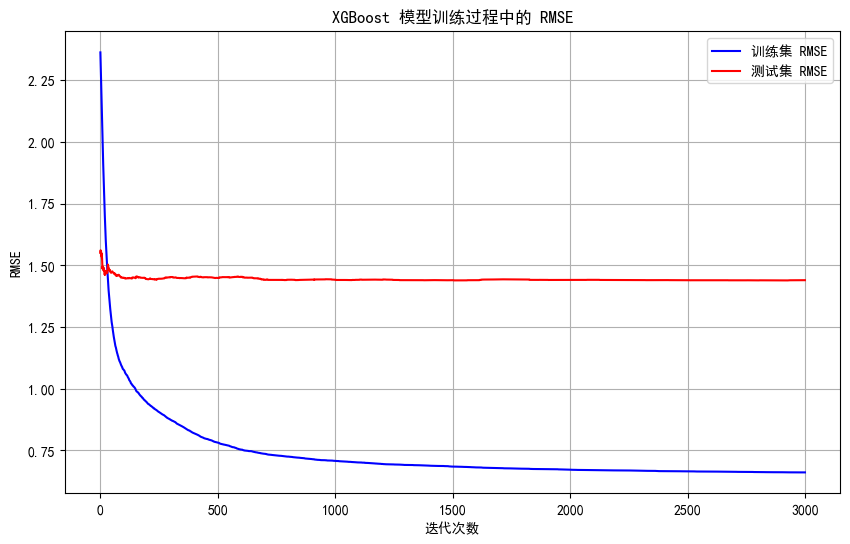

In [10]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=500
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:5.37546


[500]	train-rmse:0.63129


[1000]	train-rmse:0.51509


[1500]	train-rmse:0.47764


[2000]	train-rmse:0.46059

[2500]	train-rmse:0.44932


[2999]	train-rmse:0.44270


全部数据 MSE: 0.2052, 全部数据 R²: 0.9941

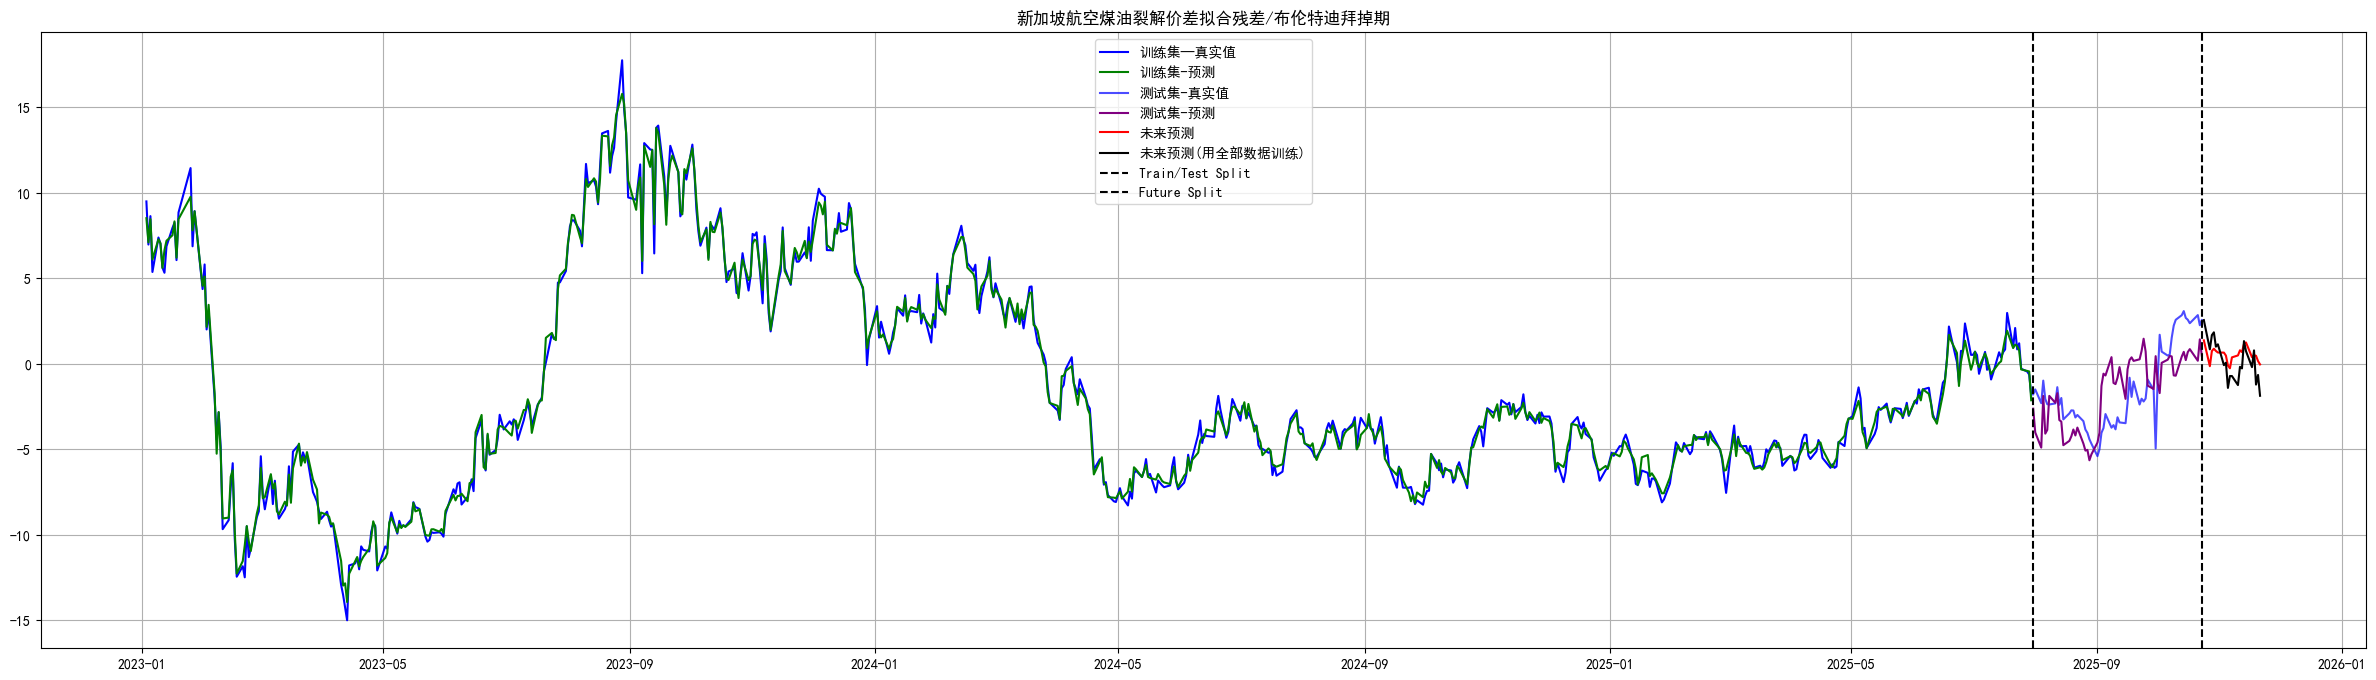

In [12]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
future_data = plot_predictions(y_test, future_data, col=True, label=True)
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('新加坡航空煤油裂解价差拟合残差/布伦特迪拜掉期')
plt.legend()
plt.grid(True)
plt.show()

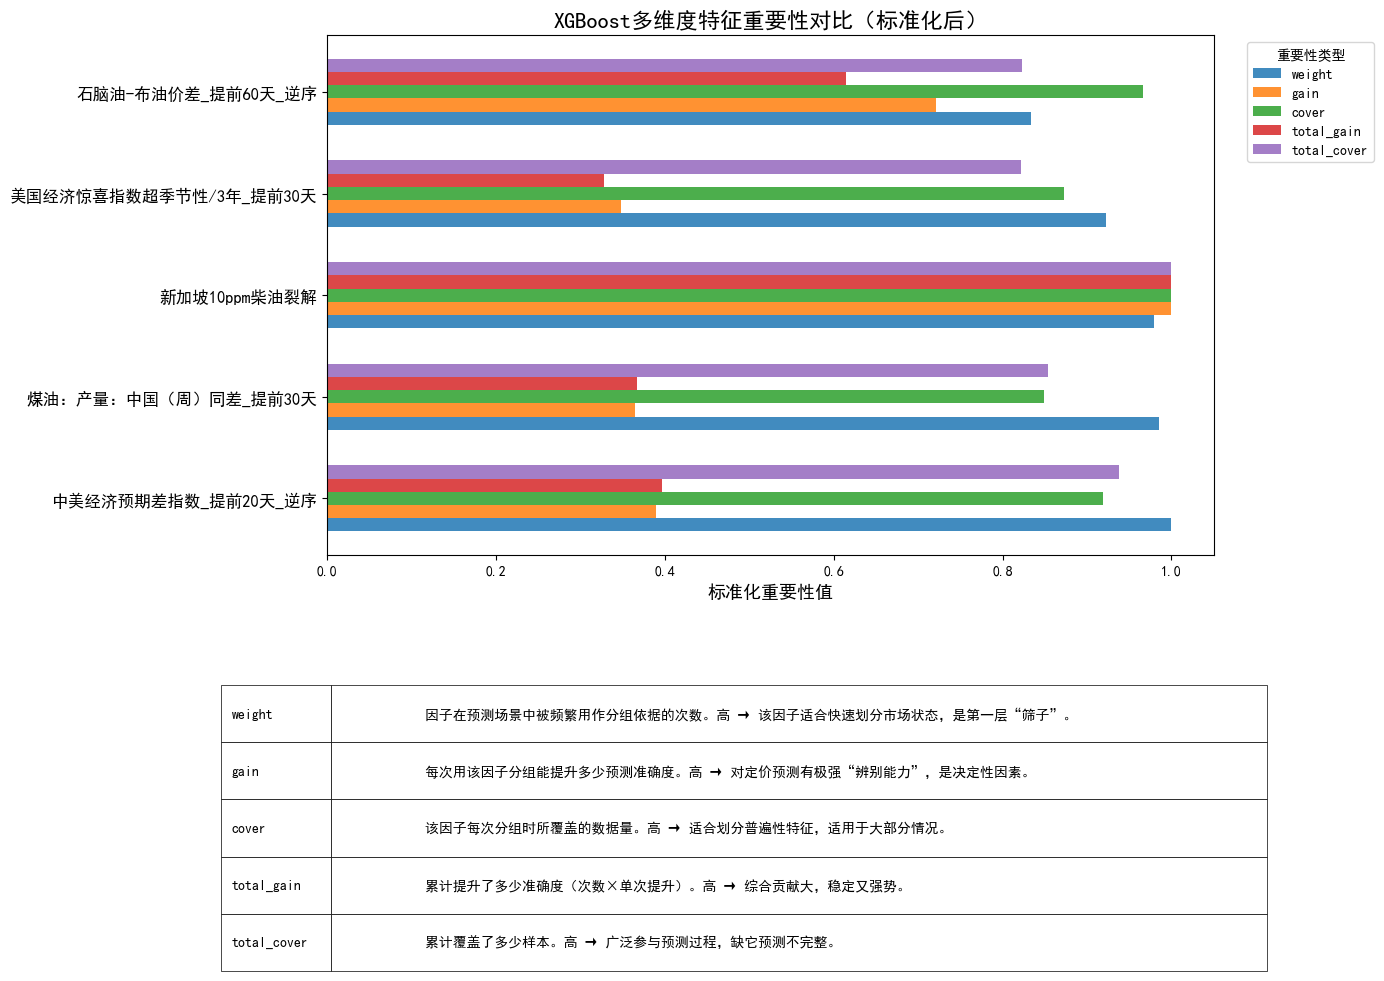

,weight,gain,cover,total_gain,total_cover
中美经济预期差指数_提前20天_逆序,1.000000,0.389017,0.918736,0.397077,0.937772
煤油：产量：中国（周）同差_提前30天,0.985043,0.364853,0.849116,0.366842,0.853746
新加坡10ppm柴油裂解,0.979701,1.000000,1.000000,1.000000,1.000000
美国经济惊喜指数超季节性/3年_提前30天,0.922543,0.347827,0.872573,0.327534,0.821665
石脑油-布油价差_提前60天_逆序,0.833868,0.721393,0.966326,0.614010,0.822483


In [13]:
plot_xgb_feature_importance(model_all, X_train)

---

In [14]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})


merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/煤油裂解价差拟合残差_布伦特迪拜_合并数据.xlsx', index=False,float_format='%.1f')

merged_df_daily

,Date,真实值,预测值
724,2025/11/21,NaN,-1.884243
723,2025/11/20,NaN,-0.666537
722,2025/11/19,NaN,-1.228498
721,2025/11/18,NaN,0.770546
720,2025/11/17,NaN,-0.208746
...,...,...,...
4,2023/01/09,7.3720,NaN
3,2023/01/06,5.3576,NaN
2,2023/01/05,8.6235,NaN
1,2023/01/04,6.9614,NaN


In [15]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel
merged_df_monthly.to_excel('eta/煤油裂解价差拟合残差_布伦特迪拜_月度数据.xlsx', index=False, float_format='%.1f')
merged_df_monthly

,Date,真实值,预测值
34,2025/11/30,NaN,-0.388933
33,2025/10/31,1.867000,0.485422
32,2025/09/30,-2.943323,-0.687442
31,2025/08/31,-2.763286,-3.931704
30,2025/07/31,0.228704,0.099642
29,2025/06/30,-0.822176,-1.063168
28,2025/05/31,-3.035345,-3.065569
27,2025/04/30,-5.124781,-5.006364
26,2025/03/31,-5.082715,-5.281049
25,2025/02/28,-4.919430,-4.852366


In [16]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "新加坡航空煤油裂解价差拟合残差/布伦特迪拜掉期 EFS"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [17]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "新加坡航空煤油裂解价差拟合残差/布伦特迪拜掉期 EFS"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


数据过滤完成: 保留 23 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/10/31, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
